In [114]:
import moleculetools as mt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [3]:
from sklearn.linear_model import LinearRegression

In [109]:
import math

In [4]:
def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

In [5]:
def build_predictors(x, y):
    x2 = np.square(x)
    y2 = np.square(y)
    x4 = np.square(x2)
    y4 = np.square(y2)
    xy = np.multiply(x, y)
    x2y2 = np.square(xy)
    return np.column_stack([x, y, x2, y2, xy])

def make_grid(radius=5, density=50):
        spacing = np.linspace(-radius, radius, density)
        X2 = np.meshgrid(spacing, spacing)
        grid_shape = X2[0].shape
        return np.reshape(X2, (2, -1)).T

In [118]:
class SurfaceStructure(mt.Structure):
    def update_relevant_coords(self):
        self.relevant_coords = self.coords[self.atom_index_list]
    
    def choose_atoms(self, atom_list=None):
        if atom_list is None:
            atom_list = list(range(1, len(self.atoms) + 1))
        self.atom_index_list = [index - 1 for index in atom_list]
        self.update_relevant_coords()
        
    def update_geometry(self):
        self.center = mt.find_center(self.relevant_coords)
        self.update_relevant_coords()
        self.main_axis = mt.find_axis(self.relevant_coords)
        self.update_relevant_coords()

    def make_surface(self, radius=5, density=50, distance=0, method='linear'):
        if method == 'linear':
            lr = LinearRegression(normalize=True)
            X = build_predictors(self.relevant_coords[:,0], self.relevant_coords[:,1])
            y = self.relevant_coords[:,2]
            lr.fit(X, y)
            print(lr.coef_)
            grid = make_grid(radius=radius, density=density)
            pred_grid = build_predictors(grid[:,0], grid[:,1])
            preds = lr.predict(pred_grid) + distance
            self.surface = np.column_stack((grid, preds))
    
    def show(self, draw_axis=True, numbering=True):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.coords[:,0],
                   self.coords[:,1],
                   self.coords[:,2], marker='o', s=30, color="black")
        if numbering:
            for i in range(self.coords.shape[0]):
                ax.text(self.coords[i,0],
                        self.coords[i,1],
                        self.coords[i,2],
                        str(i + 1))
        if draw_axis:
            n_points = 21
            axis_points = np.reshape(np.linspace(-5, 5, n_points), (n_points, 1))
            points = np.matmul(axis_points, np.reshape(self.main_axis, (1, 3))) + self.center
            ax.scatter(points[:,0], points[:,1], points[:,2], marker='.')
        try:
            ax.scatter(self.surface[:,0],
                       self.surface[:,1],
                       self.surface[:,2],
                       marker='.', s=5, alpha=0.5, c=self.surface[:,2], cmap="viridis")
        except:
            pass
        set_axes_radius(ax, self.center, 5)
        fig.savefig("{}_surface.png".format(self.name), transparent=True)
        
    def write_gjf(self, surface=None):
        link0 = "# nmr=giao b3lyp/6-31G* nosymm geom=connectivity guess=huckel"
        with open("{}.gjf".format(self.name), "w") as gjf:
            gjf.write("{}\n\ninput\n\n0 1\n".format(link0))
            for i, atom in enumerate(self.atoms):
                gjf.write("{:<2}{:>14.8f}{:>14.8f}{:>14.8f}\n".format(atom,
                                                                self.coords[i,0],
                                                                self.coords[i,1],
                                                                self.coords[i,2]))
            if surface is not None:
                for i in range(surface.shape[0]):
                    gjf.write("{:<2}{:>14.8f}{:>14.8f}{:>14.8f}\n".format("Bq",
                                                                    surface[i,0],
                                                                    surface[i,1],
                                                                    surface[i,2]))
                gjf.write("\n")
                for i in range(len(self.atoms) + surface.shape[0]):
                    gjf.write("{}\n".format(i + 1))
            #gjf.write("\n")
            #for i in range(len(self.atoms) + len(self.surface)):
            #    gjf.write("{}\n".format(i + 1))

In [110]:
class ReadSurfaceStructure(mt.Structure):
    def split_coords(self):
        surface_coords = []
        atom_coords = []
        for i, atom in enumerate(self.atoms):
            if atom == "Bq":
                surface_coords.append(self.coords[i,:])
            else:
                atom_coords.append(self.coords[i,:])
        self.surface_coords = np.array(surface_coords)
        self.atom_coords = np.array(atom_coords)
        self.center = np.array([0, 0, 0])
        
    def load_nics(self, log):
        with open(log, "r") as open_log:
            log_lines = open_log.readlines()
        isodata = -np.array([float(line.split()[4])
                             for line in log_lines
                             if "Bq   Isotropic" in line])
        #for i, item in enumerate(isodata):
        #    if abs(item) > 2000:
        #        isodata[i] = item/abs(item)
        self.isodata = isodata
    
    def show(self, numbering=True):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.atom_coords[:,0],
                   self.atom_coords[:,1],
                   self.atom_coords[:,2], marker='o', s=50, color="black")
        if numbering:
            for i in range(self.atom_coords.shape[0]):
                ax.text(self.atom_coords[i,0],
                        self.atom_coords[i,1],
                        self.atom_coords[i,2],
                        str(i + 1))
        try:
            s = ax.scatter(self.surface_coords[:,0],
                       self.surface_coords[:,1],
                       self.surface_coords[:,2],
                       marker='.', s=15, alpha=1,
                       c=self.isodata,
                       vmin=-np.amax(abs(self.isodata)),
                       vmax=np.amax(abs(self.isodata)),
                       cmap="seismic")
        except:
            pass
        set_axes_radius(ax, self.center, 5)
        ax.set_xlabel(r'x ($\AA$)')
        ax.set_ylabel(r'y ($\AA$)')
        ax.set_zlabel(r'z ($\AA$)')
        fig.colorbar(s, orientation='vertical', fraction=0.03)
        fig.savefig('temp.png', transparent=True)
    
    def show_2d(self, numbering=False):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(self.atom_coords[:,0],
                   self.atom_coords[:,1], marker='o', s=50, color="black")
        if numbering:
            for i in range(self.atom_coords.shape[0]):
                ax.text(self.atom_coords[i,0],
                        self.atom_coords[i,1],
                        str(i + 1))
        #try:
        #    s = ax.tricontourf(self.surface_coords[:,0],
        #               self.surface_coords[:,1],
        #               marker='.', s=15, alpha=1,
        #               c=self.isodata,
        #               vmin=-np.amax(abs(self.isodata)),
        #               vmax=np.amax(abs(self.isodata)),
        #               cmap="seismic")

        vmin = -np.amax(abs(self.isodata))
        vmax = np.amax(abs(self.isodata))
        levels = np.linspace(vmin, vmax,
                             np.sqrt(self.surface_coords.shape[0]))
        
        tricontourf_ = ax.tricontourf(self.surface_coords[:,0],
                       self.surface_coords[:,1],
                       self.isodata, levels=levels, vmin=vmin, vmax=vmax,
                       cmap='seismic')
        
        ax.margins(0,0)
        ax.axis("scaled")
        ax.set_xlim(np.amin(self.surface_coords[:,0]),
                    np.amax(self.surface_coords[:,0]))
        ax.set_ylim(np.amin(self.surface_coords[:,1]),
                    np.amax(self.surface_coords[:,1]))
        ax.set_xlabel(r'x ($\AA$)')
        ax.set_ylabel(r'y ($\AA$)')
        cbar = fig.colorbar(tricontourf_,
                            orientation='vertical',
                            fraction=0.03,
                            extend='both', label="NICS (ppm)",
                            ticks=[math.ceil(vmin), 0, math.floor(vmax)])
        #cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
        plt.tight_layout()
        fig.savefig("{}.png".format(self.name), transparent=True)

Molecule instantiated!



<IPython.core.display.Javascript object>


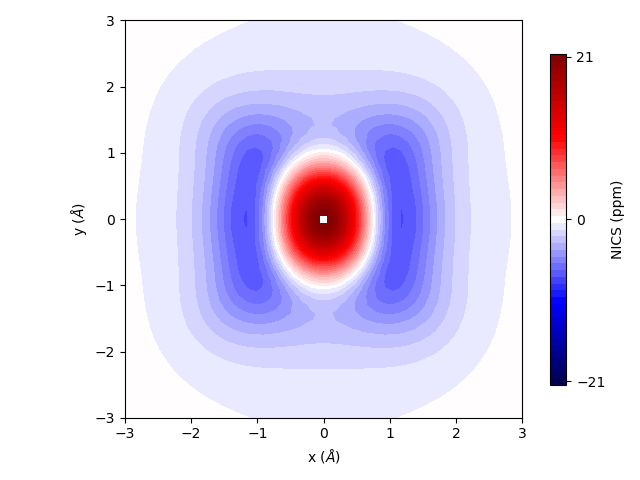

In [116]:
atoms, coords = mt.read_log("cbd.log")
solved = ReadSurfaceStructure(atoms, coords, name="cbd")
solved.split_coords()
solved.load_nics("cbd.log")
solved.show_2d(numbering=False)

Molecule instantiated!

[ 0.11270967  0.08596852 -0.00749286  0.00701229  0.27490878]


<IPython.core.display.Javascript object>


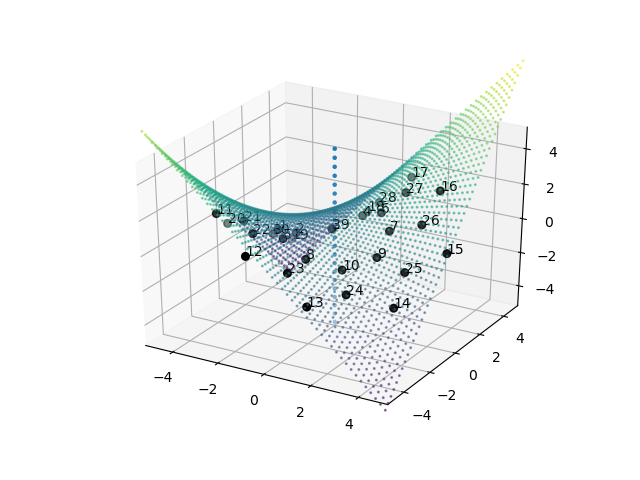

In [121]:
els, coords = mt.read_xyz("asn10.xyz")
system = SurfaceStructure(els, coords, name="asn10")
system.choose_atoms()
system.translate_to_center()
system.rotate_to_z()

#system.choose_atoms(list(range(1, 11)))
system.choose_atoms()
system.make_surface(distance=1)
system.write_gjf(system.surface)
system.show()

Molecule instantiated!



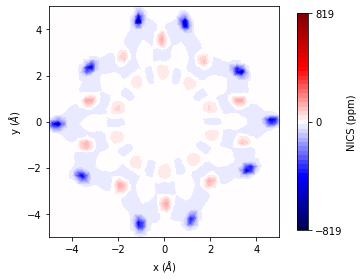

In [101]:
atoms, coords = mt.read_log("system.log")
solved = ReadSurfaceStructure(atoms, coords, name="asn10")
solved.split_coords()
solved.load_nics("system.log")
solved.show_2d(numbering=False)

Molecule instantiated!

[0. 0. 0. 0. 0.]


/Users/oscar/git/gaussiantools/nics/moleculetools.py:10: RuntimeWarning: invalid value encountered in true_divide
  return vector/np.linalg.norm(vector)


<IPython.core.display.Javascript object>


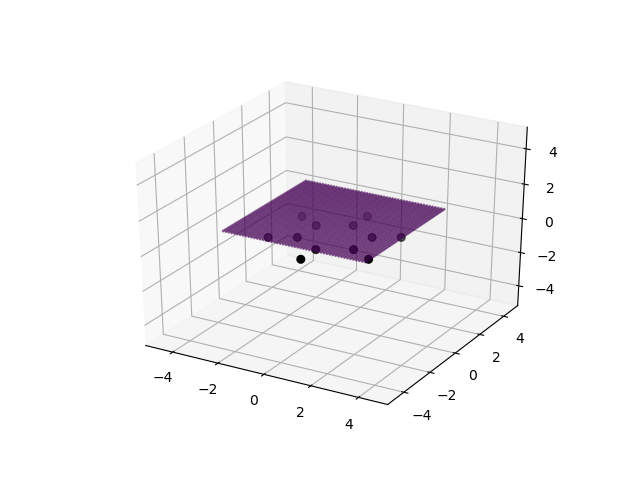

In [119]:
els, coords = mt.read_xyz("benzene.xyz")
system = SurfaceStructure(els, coords, name="benzene")
system.choose_atoms()
system.translate_to_center()

system.make_surface(radius=3, distance=1)
system.write_gjf(cbd.surface)
system.show(numbering=False)

Molecule instantiated!

[-0.57960625  0.80644127 -0.64255853 -0.56219999  0.36155961]


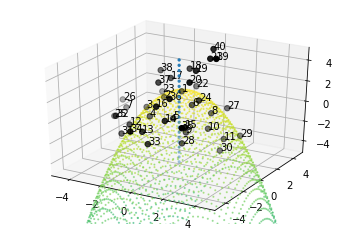

In [104]:
els, coords = mt.read_xyz("stx.xyz")
stx = SurfaceStructure(els, coords, name='stx')
stx.choose_atoms([1, 2, 3, 4, 5, 6, 8, 9, 10])
stx.translate_to_center()
stx.rotate_to_z()

stx.make_surface()
stx.show()